In [1]:
import re
import glob
import joblib
import statistics
import matplotlib
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
# for illustration

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times'

In [7]:
p_values = np.arange(0, 10000, 100)
e_values = np.arange(0, 1, 0.01)
E_values, P_values = np.meshgrid(e_values, p_values)

In [33]:
def collect_best_param(output_dir):
    num_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    best_p = []
    best_e = []
    best_id = []
    best_r0 = []


    f = open(output_dir + '/best_param.txt')
    line = f.readlines()
    f.close()

    for d_ in range(len(line)):

        line_d = line[d_]

        if line_d[0] in num_list:

            t_count = 0

            for j in range(len(line_d)):
                if line_d[j] == '\t':
                    if t_count == 0:
                        line_p = float(line_d[0:j])
                        t_count_for_p = j
                    elif t_count == 1:
                        line_e = float(line_d[t_count_for_p:j])
                        t_count_for_e = j
                    elif t_count == 2:
                        line_id = float(line_d[t_count_for_e:j])
                        t_count_for_id = j

                    t_count += 1

                if line_d[j] == '\n':
                    line_r0 = float(line_d[t_count_for_id:j])

            best_p.append(line_p)
            best_e.append(line_e)
            best_id.append(line_id)
            best_r0.append(line_r0)
            
    return best_p, best_e, best_id, best_r0

def rotation_o(u, t, deg=False):

    if deg == True:
        t = np.deg2rad(t)

    R = np.array([[np.cos(t), -np.sin(t)],
                  [np.sin(t),  np.cos(t)]])

    return  np.dot(R, u)

def simulator_inf(tau_max, p, epsilon):

    gamma = 10
    c = 10
    beta = 0.0001
    micro = 0.01
    dt = 0.001


    cc = p/(p + 1000)

    Ta = 1000
    Ia = 0
    Vi = 1
    Vni = 0

    Ta_range = [Ta]
    Ia_range = [Ia]
    Vi_range = [Vi]
    Vni_range = [Vni]

    for i in range(1, int(tau_max*1000)):

        Taa = Ta + (gamma-beta*Ta*Vi-micro*Ta)*dt

        Iaa = Ia + (beta*Ta*Vi-cc*Ia)*dt

        Vii = Vi + (epsilon*p*Ia-c*Vi)*dt

        Vnii = Vni + ((1-epsilon)*p*Ia-c*Vni)*dt

        Ia = Iaa
        Ta = Taa
        Vi = Vii
        Vni = Vnii

        Ta_range.append(Ta)
        Ia_range.append(Ia)
        Vi_range.append(Vi)
        Vni_range.append(Vni)

    return np.array(Vi_range)

def calc_vl_peak(vi_p, vi_e):
    
    AUC50 = 1000000
    a_value = 7.5

    vi_peak = []

    for ind_p, ind_e in zip(vi_p, vi_e):
        print(ind_p, ind_e)
        ind_vi_range = simulator(1000, ind_p, ind_e)
        ind_inf_ = 1000*(AUC50**a_value/((sum(ind_vi_range)/1000)**a_value+AUC50**a_value))
        ind_vi_range = simulator(ind_inf_, ind_p, ind_e)

        vi_peak.append(max(ind_vi_range))
    
    return vi_peak

def simulator(tau_max, p, epsilon):

    gamma = 10
    c = 10
    beta = 0.0001
    micro = 0.01
    dt = 0.001


    cc = p/(p + 1000)

    Ta = 1000
    Ia = 0
    Vi = 1
    Vni = 0

    Ta_range = [Ta]
    Ia_range = [Ia]
    Vi_range = [Vi]
    Vni_range = [Vni]

    for i in range(1, int(tau_max*1000)):

        Taa = Ta + (gamma-beta*Ta*Vi-micro*Ta)*dt

        Iaa = Ia + (beta*Ta*Vi-cc*Ia)*dt

        Vii = Vi + (epsilon*p*Ia-c*Vi)*dt

        Vnii = Vni + ((1-epsilon)*p*Ia-c*Vni)*dt

        Ia = Iaa
        Ta = Taa
        Vi = Vii
        Vni = Vnii

        Ta_range.append(Ta)
        Ia_range.append(Ia)
        Vi_range.append(Vi)
        Vni_range.append(Vni)

    return Vi_range


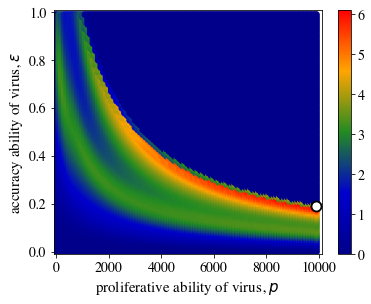

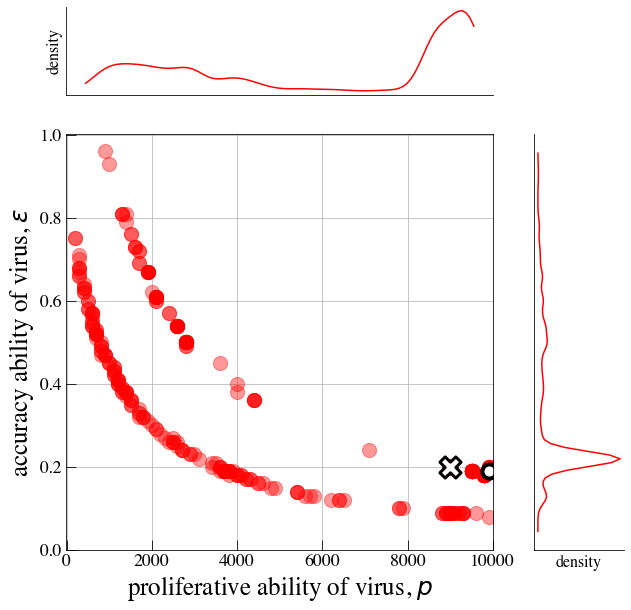

In [23]:
# for Fig 2

flu_dir = 'data_YYYYMMDD/shape_100.0_scale_0.03'

colors = ["darkblue", "mediumblue", "forestgreen", "orange", "red"]
nodes = [0.0, 0.25, 0.5, 0.75, 1.0]
cmap_self = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

iter_r0 = joblib.load(flu_dir + '/ind_r0.pkl')

ind_iter = np.array(iter_r0[166])

fig = plt.figure(figsize = (6, 4.5))

ax = fig.add_subplot(111)

mappable = ax.scatter(P_values, E_values, c = ind_iter.reshape(100, 100), cmap = cmap_self)


b = ind_iter.tolist().index(max(ind_iter))
b_p = p_values[int(b / 100)]
b_e = e_values[b % 100]

plt.scatter(b_p, b_e, fc = 'white', ec = 'black', s = 100, linewidth = 1.8)

pp = fig.colorbar(mappable, ax = ax)
pp.ax.tick_params(labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.set_xlabel('proliferative ability of virus, ' + '$\it{ p }$', fontsize = 15)
ax.set_ylabel('accuracy ability of virus, ' + r'$\epsilon$', fontsize = 15)
plt.xlim(-100, 10100)
plt.ylim(-0.01, 1.01)

plt.plot()

data_number_ = 500
test_ind = 166

vi_p, vi_e, _, _ = collect_best_param(flu_dir)

vi_p_med, vi_e_med = statistics.median(vi_p), statistics.median(vi_e)

vi_p, vi_e = vi_p[:data_number_], vi_e[:data_number_]

kde_model = gaussian_kde(vi_p, bw_method=0.1)
x_grid = np.linspace(0, 10000, num=100)
kernel_p = kde_model(x_grid)

kde_model = gaussian_kde(vi_e, bw_method=0.1)
x_grid = np.linspace(0, 1.0, num=100)
kernel_e = kde_model(x_grid)

#rotate
kernel_e_x = rotation_o(np.vstack((np.linspace(0, 1, 100), -kernel_e)), np.pi/2)[0]
kernel_e_y = rotation_o(np.vstack((np.linspace(0, 1, 100), -kernel_e)), np.pi/2)[1]

fig = plt.figure(figsize=(10, 10))
grid_master = GridSpec(nrows = 30, ncols = 30, height_ratios = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

gs_1 = GridSpecFromSubplotSpec(nrows = 2, ncols = 23, subplot_spec = grid_master[0:5, 0:23])
axes_1 = fig.add_subplot(gs_1[:, :])
axes_1.plot(np.array(kernel_p), color = 'red')
axes_1.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
axes_1.axes.xaxis.set_visible(False)
axes_1.tick_params(length = 0)
axes_1.set_ylabel('density', fontsize = 16)
axes_1.spines['right'].set_visible(False)
axes_1.spines['top'].set_visible(False)

gs_2 = GridSpecFromSubplotSpec(nrows = 23, ncols = 23, subplot_spec = grid_master[7:30, 0:23])
axes_2 = fig.add_subplot(gs_2[:, :])
axes_2.scatter(np.array(vi_p), np.array(vi_e), color = 'red', s=200, alpha=0.4, zorder = 1)
axes_2.scatter(vi_p_med, vi_e_med, marker = 'X', ec = 'black', color = 'white', s=450, linewidth=3, zorder = 2)
axes_2.scatter(np.array([vi_p[test_ind]]), np.array([vi_e[test_ind]]), ec = 'black', fc = 'white', s=200, linewidth=4, zorder = 2)
axes_2.tick_params(direction = 'in', length = 10)
axes_2.grid(alpha = 0.7, linewidth = 1)
axes_2.set_axisbelow(True)
axes_2.set_xlim(-10, 10010)
axes_2.set_ylim(-0.001, 1.001)
axes_2.set_ylim(-0.001, 1.001)
axes_2.set_xlabel('proliferative ability of virus, ' + '$\it{ p }$', fontsize = 25)
axes_2.set_ylabel('accuracy ability of virus, ' + r'$\epsilon$', fontsize = 25)

gs_3 = GridSpecFromSubplotSpec(nrows = 23, ncols = 2, subplot_spec = grid_master[7:30, 25:30])
axes_3 = fig.add_subplot(gs_3[:, :])
axes_3.plot(kernel_e_x, kernel_e_y, color = 'red')
axes_3.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
axes_3.axes.yaxis.set_visible(False)
axes_3.tick_params(length = 0)
axes_3.set_xlabel('density', fontsize = 16)
axes_3.spines['right'].set_visible(False)
axes_3.spines['top'].set_visible(False)

plt.setp(axes_1.get_xticklabels(), fontsize = 13)
plt.setp(axes_1.get_yticklabels(), fontsize = 13)
plt.setp(axes_2.get_xticklabels(), fontsize = 18)
plt.setp(axes_2.get_yticklabels(), fontsize = 18)
plt.setp(axes_3.get_xticklabels(), fontsize = 13)
plt.setp(axes_3.get_yticklabels(), fontsize = 13)

plt.plot()


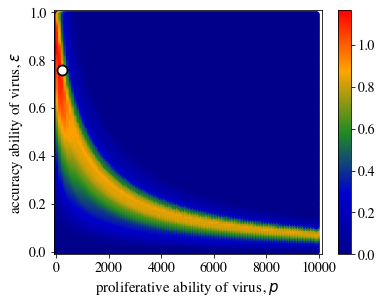

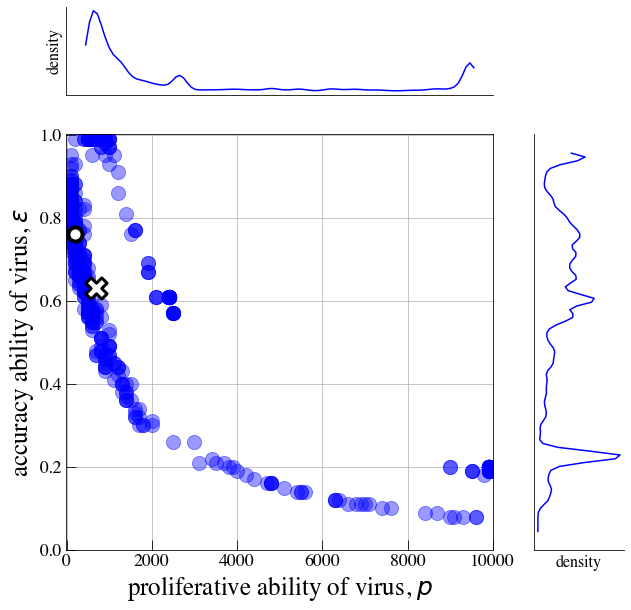

In [24]:
borna_dir = 'data_YYYYMMDD/shape_0.12_scale_10.0'

colors = ["darkblue", "mediumblue", "forestgreen", "orange", "red"]
nodes = [0.0, 0.25, 0.5, 0.75, 1.0]
cmap_self = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

iter_r0 = joblib.load(borna_dir + '/ind_r0.pkl')

ind_iter = np.array(iter_r0[90])

fig = plt.figure(figsize = (6, 4.5))

ax = fig.add_subplot(111)

mappable = ax.scatter(P_values, E_values, c = ind_iter.reshape(100, 100), cmap = cmap_self)


b = ind_iter.tolist().index(max(ind_iter))
b_p = p_values[int(b / 100)]
b_e = e_values[b % 100]

plt.scatter(b_p, b_e, fc = 'white', ec = 'black', s = 100, linewidth = 1.8)

pp = fig.colorbar(mappable, ax = ax)
pp.ax.tick_params(labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.set_xlabel('proliferative ability of virus, ' + '$\it{ p }$', fontsize = 15)
ax.set_ylabel('accuracy ability of virus, ' + r'$\epsilon$', fontsize = 15)
plt.xlim(-100, 10100)
plt.ylim(-0.01, 1.01)

plt.plot()

data_number_ = 500
test_ind = 90

borna_dir = '/shape_0.12_scale_10.0'

vi_p, vi_e, _, _ = collect_best_param(borna_dir)

vi_p_med, vi_e_med = statistics.median(vi_p), statistics.median(vi_e)

vi_p, vi_e = vi_p[:data_number_], vi_e[:data_number_]

kde_model = gaussian_kde(vi_p, bw_method=0.05)
x_grid = np.linspace(0, 10000, num=100)
kernel_p = kde_model(x_grid)

kde_model = gaussian_kde(vi_e, bw_method=0.05)
x_grid = np.linspace(0, 1.0, num=100)
kernel_e = kde_model(x_grid)

#rotate
kernel_e_x = rotation_o(np.vstack((np.linspace(0, 1, 100), -kernel_e)), np.pi/2)[0]
kernel_e_y = rotation_o(np.vstack((np.linspace(0, 1, 100), -kernel_e)), np.pi/2)[1]

fig = plt.figure(figsize=(10, 10))
grid_master = GridSpec(nrows = 30, ncols = 30, height_ratios = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

gs_1 = GridSpecFromSubplotSpec(nrows = 2, ncols = 23, subplot_spec = grid_master[0:5, 0:23])
axes_1 = fig.add_subplot(gs_1[:, :])
axes_1.plot(np.array(kernel_p), color = 'blue')
axes_1.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
axes_1.axes.xaxis.set_visible(False)
axes_1.tick_params(length = 0)
axes_1.set_ylabel('density', fontsize = 16)
axes_1.spines['right'].set_visible(False)
axes_1.spines['top'].set_visible(False)

gs_2 = GridSpecFromSubplotSpec(nrows = 23, ncols = 23, subplot_spec = grid_master[7:30, 0:23])
axes_2 = fig.add_subplot(gs_2[:, :])
axes_2.scatter(np.array(vi_p), np.array(vi_e), color = 'blue', s=200, alpha=0.4, zorder = 1)
axes_2.scatter(vi_p_med, vi_e_med, marker = 'X', ec = 'black', color = 'white', s=450, linewidth=3, zorder = 2)
axes_2.scatter(np.array([vi_p[test_ind]]), np.array([vi_e[test_ind]]), ec = 'black', fc = 'white', s=200, linewidth=4, zorder = 2)
axes_2.tick_params(direction = 'in', length = 10)
axes_2.grid(alpha = 0.7, linewidth = 1)
axes_2.set_axisbelow(True)
axes_2.set_xlim(-10, 10010)
axes_2.set_ylim(-0.001, 1.001)
axes_2.set_ylim(-0.001, 1.001)
axes_2.set_xlabel('proliferative ability of virus, ' + '$\it{ p }$', fontsize = 25)
axes_2.set_ylabel('accuracy ability of virus, ' + r'$\epsilon$', fontsize = 25)

gs_3 = GridSpecFromSubplotSpec(nrows = 23, ncols = 2, subplot_spec = grid_master[7:30, 25:30])
axes_3 = fig.add_subplot(gs_3[:, :])
axes_3.plot(kernel_e_x, kernel_e_y, color = 'blue')
axes_3.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
axes_3.axes.yaxis.set_visible(False)
axes_3.tick_params(length = 0)
axes_3.set_xlabel('density', fontsize = 16)
axes_3.spines['right'].set_visible(False)
axes_3.spines['top'].set_visible(False)

plt.setp(axes_1.get_xticklabels(), fontsize = 13)
plt.setp(axes_1.get_yticklabels(), fontsize = 13)
plt.setp(axes_2.get_xticklabels(), fontsize = 18)
plt.setp(axes_2.get_yticklabels(), fontsize = 18)
plt.setp(axes_3.get_xticklabels(), fontsize = 13)
plt.setp(axes_3.get_yticklabels(), fontsize = 13)

plt.plot()


In [20]:
# for Fig 3

all_dir = 'data_YYYYMMDD/data_20210918'
all_links = glob.glob("{}/*".format(all_dir))
len(all_links)

441

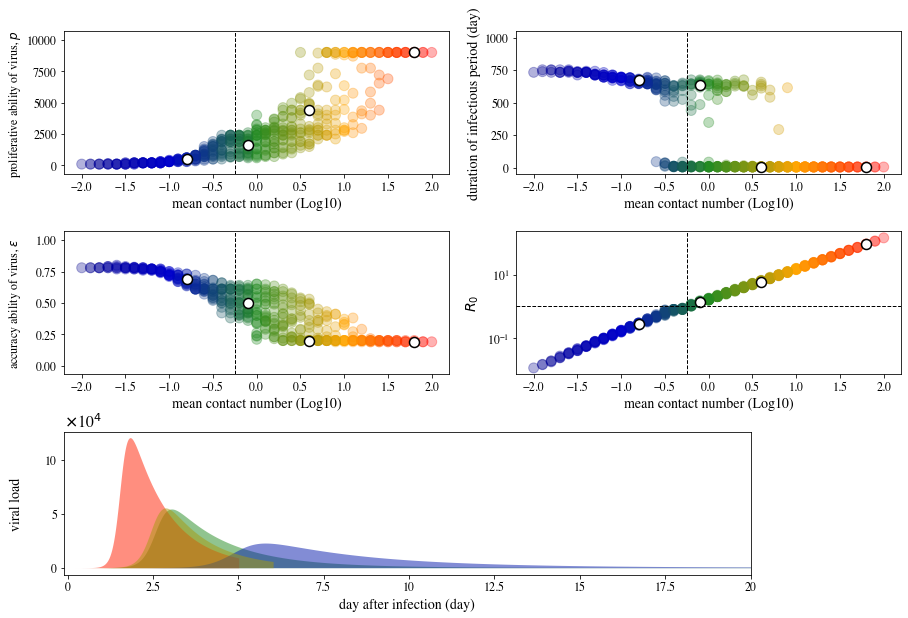

In [26]:
ind_ps = []
ind_es = []
ind_inf_s = []
best_r0s = []
ind_means = []

for ind_link in all_links:

    num_ = re.findall(r"\d+", ind_link[104:])

    ind_shape, ind_scale = float(num_[0] + '.' + num_[1]), float(num_[2] + '.' + num_[3])
    
    ind_data = np.array(collect_best_param(ind_link))
    ind_p = statistics.median(ind_data[0, :])
    ind_e = statistics.median(ind_data[1, :])
    ind_inf_ = statistics.median(ind_data[2, :])
    best_r0 = statistics.median(ind_data[3, :])

            
    ind_ps.append(ind_p)
    ind_es.append(ind_e)
    ind_inf_s.append(ind_inf_)
    best_r0s.append(best_r0)
    
    ind_means.append(np.log10(ind_shape*ind_scale))
    
r1_line = (ind_means[324] + ind_means[431])/2

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot2grid((3,6), (0,0), colspan=3)
ax2 = plt.subplot2grid((3,6), (1,0), colspan=3)
ax3 = plt.subplot2grid((3,6), (0,3), colspan=3)
ax4 = plt.subplot2grid((3,6), (1,3), colspan=3)
ax5 = plt.subplot2grid((3,6), (2,0), colspan=5)


ax1.scatter(ind_means, ind_ps, s  = 100, alpha = 0.3, c=ind_means, vmin=min(ind_means), vmax=max(ind_means), cmap=cmap_self)

ax1.set_ylim(-700, 10700)
ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_ylabel('proliferative ability of virus, ' + '$\it{ p }$', fontsize = 12)
ax1.set_xlabel('mean contact number (Log10)', fontsize = 14)

ax2.scatter(ind_means, ind_es, s  = 100, alpha = 0.3, c=ind_means, vmin=min(ind_means), vmax=max(ind_means), cmap=cmap_self)

ax2.set_ylim(-0.07, 1.07)
ax2.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)
ax2.set_ylabel('accuracy ability of virus, ' + r'$\epsilon$', fontsize = 12)
ax2.set_xlabel('mean contact number (Log10)', fontsize = 14)


ax3.scatter(ind_means, ind_inf_s, s  = 100, alpha = 0.3, c=ind_means, vmin=min(ind_means), vmax=max(ind_means), cmap=cmap_self)

ax3.set_ylim(-50, 1050)
ax3.tick_params(axis='y', labelsize=12)
ax3.tick_params(axis='x', labelsize=12)
ax3.set_ylabel('duration of infectious period (day)', fontsize = 14)
ax3.set_xlabel('mean contact number (Log10)', fontsize = 14)


ax4.scatter(ind_means, best_r0s, s  = 100, alpha = 0.3, c=ind_means, vmin=min(ind_means), vmax=max(ind_means), cmap=cmap_self)

ax4.set_yscale('log')
ax4.tick_params(axis='y', labelsize=12)
ax4.tick_params(axis='x', labelsize=12)
ax4.set_ylabel('$R_{0}$', fontsize = 14)
ax4.set_xlabel('mean contact number (Log10)', fontsize = 14)

AUC50 = 1000000
a_value = 7.5
color_list = ['#238b21', '#ff1f00', '#061aac', '#a79a0d']

i_list = [40, 118, 239, 363]

for i in i_list:
    ind_p = ind_ps[i]
    ind_e = ind_es[i]
    ind_inf_ = ind_inf_s[i]
    ind_vi_range = simulator_inf(ind_inf_, ind_p, ind_e)
    ax5.fill_between(np.arange(len(ind_vi_range)), ind_vi_range, np.array([0 for _ in range(len(ind_vi_range))]), facecolor=color_list[i_list.index(i)], alpha=0.5)
    
    ax1.scatter(ind_means[i], ind_ps[i], s  = 100, alpha = 1, fc='white', ec = 'black', linewidth = 1.5)
    ax2.scatter(ind_means[i], ind_es[i], s  = 100, alpha = 1, fc='white', ec = 'black', linewidth = 1.5)
    ax3.scatter(ind_means[i], ind_inf_s[i], s  = 100, alpha = 1, fc='white', ec = 'black', linewidth = 1.5)
    ax4.scatter(ind_means[i], best_r0s[i], s  = 100, alpha = 1, fc='white', ec = 'black', linewidth = 1.5)
    
ax1.axvline(x=r1_line, ymin=0, ymax=1, color = 'black', linestyle = 'dashed', linewidth = 1)
ax2.axvline(x=r1_line, ymin=0, ymax=1, color = 'black', linestyle = 'dashed', linewidth = 1)
ax3.axvline(x=r1_line, ymin=0, ymax=1, color = 'black', linestyle = 'dashed', linewidth = 1)
ax4.axvline(x=r1_line, ymin=0, ymax=1, color = 'black', linestyle = 'dashed', linewidth = 1)
ax4.axhline(y=1, xmin=0, xmax=1, color = 'black', linestyle = 'dashed', linewidth = 1)

ax5.set_xlim(-100, 20000)
ax5.tick_params(axis='y', labelsize=12)
ax5.set_ylabel('viral load', fontsize = 14)
ax5.set_xlabel('day after infection (day)', fontsize = 14)
ax5.set_xticks([0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000])
ax5.set_xticklabels(['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20'], fontsize = 12)
ax5.text(0.0, 1.03, r'$\times$'+'10$^4$', color = 'black', size = 16, transform = ax5.transAxes)
ax5.set_yticks([0, 50000, 100000])
ax5.set_yticklabels(['0', '5', '10'], fontsize = 12)

fig.align_ylabels([ax1, ax2, ax5])
fig.align_ylabels([ax3, ax4])
plt.subplots_adjust(wspace=0.8, hspace=0.4)

plt.plot()


[]

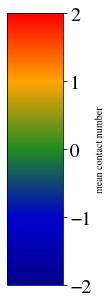

In [22]:
norm = matplotlib.colors.Normalize(vmin=min(ind_means), vmax=max(ind_means))

fig, ax = plt.subplots(figsize=(1, 5))
cmap = cmap_self
cbar = matplotlib.colorbar.ColorbarBase(
    ax=ax,
    cmap=cmap,
    norm=norm,
    orientation="vertical",
    label="mean contact number (Log10)",
)
ax.tick_params(axis='y', labelsize=20)

plt.plot()

In [34]:
data_number_ = 500

print('flu')
flu_dir = 'data_YYYYMMDD/shape_1000.0_scale_0.002'

vi_p, vi_e, vi_id_1, _ = collect_best_param(flu_dir)
vi_p, vi_e, vi_id_1 = vi_p[:data_number_], vi_e[:data_number_], vi_id_1[:data_number_]

flu_vi_peak = calc_vl_peak(vi_p, vi_e)

print('borna')
borna_dir = 'data_YYYYMMDD/shape_0.12_scale_10.0'

vi_p, vi_e, vi_id_2, _ = collect_best_param(borna_dir)
vi_p, vi_e, vi_id_2 = vi_p[:data_number_], vi_e[:data_number_], vi_id_2[:data_number_]

borna_vi_peak = calc_vl_peak(vi_p, vi_e)


flu
400.0 0.64
1600.0 0.33
3300.0 0.22
500.0 0.59
500.0 0.59
9900.0 0.19
5200.0 0.14
9800.0 0.18
500.0 0.59
9400.0 0.09
1500.0 0.35000000000000003
9900.0 0.19
9000.0 0.2
2100.0 0.61
1300.0 0.39
9500.0 0.19
1600.0 0.34
9900.0 0.19
9000.0 0.2
9000.0 0.2
500.0 0.6
9900.0 0.19
2800.0 0.5
9000.0 0.2
300.0 0.67
9900.0 0.19
1000.0 0.45
9500.0 0.19
1000.0 0.45
9900.0 0.19
9900.0 0.19
9800.0 0.18
9000.0 0.2
2700.0 0.54
4200.0 0.17
2800.0 0.5
4100.0 0.18
3900.0 0.19
9000.0 0.2
1300.0 0.39
9900.0 0.19
9800.0 0.09
3200.0 0.21
6500.0 0.12
4400.0 0.36
1900.0 0.67
4000.0 0.18
9000.0 0.2
9800.0 0.18
1300.0 0.81
900.0 0.9500000000000001
8800.0 0.09
1700.0 0.72
1900.0 0.32
9000.0 0.2
1100.0 0.42
9800.0 0.18
1600.0 0.33
1200.0 0.41000000000000003
9500.0 0.09
9000.0 0.2
9300.0 0.09
9900.0 0.19
800.0 0.49
9900.0 0.19
2600.0 0.26
9000.0 0.2
9800.0 0.18
9000.0 0.2
1300.0 0.81
1700.0 0.72
9500.0 0.19
8900.0 0.09
9500.0 0.19
9000.0 0.2
1300.0 0.81
1300.0 0.39
9800.0 0.18
5000.0 0.15
9900.0 0.19
9900.0 0.19
240

9900.0 0.19
6800.0 0.11
400.0 0.66
9900.0 0.2
500.0 0.6
100.0 0.8200000000000001
400.0 0.61
200.0 0.72
900.0 0.43
200.0 0.76
900.0 0.47000000000000003
5400.0 0.14
800.0 0.48
1600.0 0.77
1000.0 0.93
300.0 0.66
400.0 0.7000000000000001
700.0 0.55
9900.0 0.19
700.0 0.47000000000000003
1300.0 0.4
400.0 0.6900000000000001
200.0 0.78
800.0 0.51
9900.0 0.2
100.0 0.86
300.0 0.7000000000000001
200.0 0.67
6300.0 0.12
4400.0 0.17
200.0 0.71
500.0 0.99
1400.0 0.38
9600.0 0.08
9900.0 0.2
200.0 0.8200000000000001
200.0 0.79
800.0 0.48
200.0 0.73
100.0 0.78
200.0 0.77
100.0 0.89
500.0 0.62
1800.0 0.3
100.0 0.74
400.0 0.71
500.0 0.5700000000000001
500.0 0.62
400.0 0.99
100.0 0.88
200.0 0.74
700.0 0.48
200.0 0.72
100.0 0.78
900.0 0.99
200.0 0.74
9900.0 0.2
2400.0 0.61
2400.0 0.61
2500.0 0.5700000000000001
9900.0 0.2
3500.0 0.21
300.0 0.71
100.0 0.87
400.0 0.78
100.0 0.85
1000.0 0.46
100.0 0.8
100.0 0.8300000000000001
900.0 0.44
100.0 0.81
4700.0 0.16
9500.0 0.19
100.0 0.78
200.0 0.78
900.0 0.9500000000

In [35]:
flu_dir = 'data_YYYYMMDD/shape_1000.0_scale_0.002'

_, _, vi_id_1, _ = collect_best_param(flu_dir)

borna_dir = 'data_YYYYMMDD/shape_0.12_scale_10.0'

_, _, vi_id_2, _ = collect_best_param(borna_dir)

kde_model = gaussian_kde(vi_id_1, bw_method=0.1)
x_grid = np.linspace(min(vi_id_1), max(vi_id_1), num=100)
kernel_vi_id_1 = kde_model(x_grid)

kde_model = gaussian_kde(flu_vi_peak, bw_method=0.1)
x_grid = np.linspace(min(flu_vi_peak), max(flu_vi_peak), num=100)
kernel_flu_vi_peak = kde_model(x_grid)

#rotate
kernel_flu_vi_peak_x = rotation_o(np.vstack((np.linspace(0, 1, 100), -kernel_flu_vi_peak)), np.pi/2)[0]
kernel_flu_vi_peak_y = rotation_o(np.vstack((np.linspace(0, 1, 100), -kernel_flu_vi_peak)), np.pi/2)[1]

kde_model = gaussian_kde(vi_id_2, bw_method=0.1)
x_grid = np.linspace(min(vi_id_2), max(vi_id_2), num=100)
kernel_vi_id_2 = kde_model(x_grid)

kde_model = gaussian_kde(borna_vi_peak, bw_method=0.1)
x_grid = np.linspace(min(borna_vi_peak), max(borna_vi_peak), num=100)
kernel_borna_vi_peak = kde_model(x_grid)

#rotate
kernel_borna_vi_peak_x = rotation_o(np.vstack((np.linspace(0, 1, 100), -kernel_borna_vi_peak)), np.pi/2)[0]
kernel_borna_vi_peak_y = rotation_o(np.vstack((np.linspace(0, 1, 100), -kernel_borna_vi_peak)), np.pi/2)[1]

flu
median point 
 day after infection (day) : 5.060260888772835
 viral load peak 100638.75193048608
borna
median point 
 day after infection (day) : 672.865854224675
 viral load peak 24675.049605728917


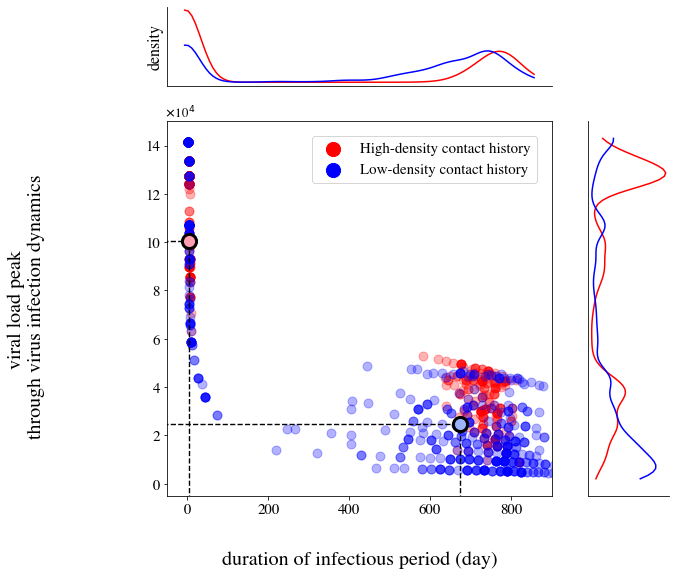

In [47]:
fig = plt.figure(figsize=(9, 9))
grid_master = GridSpec(nrows = 30, ncols = 30, height_ratios = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

gs_1 = GridSpecFromSubplotSpec(nrows = 2, ncols = 23, subplot_spec = grid_master[0:5, 0:23])
axes_1 = fig.add_subplot(gs_1[:, :])
axes_1.axes.xaxis.set_visible(False)
axes_1.plot(np.array(kernel_vi_id_1), color = 'red')
axes_1.plot(np.array(kernel_vi_id_2), color = 'blue')

axes_1.spines['right'].set_visible(False)
axes_1.spines['top'].set_visible(False)

axes_1.tick_params(length = 0)
axes_1.set_ylabel('density', fontsize = 16)

axes_1.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

gs_2 = GridSpecFromSubplotSpec(nrows = 23, ncols = 23, subplot_spec = grid_master[7:30, 0:23])
axes_2 = fig.add_subplot(gs_2[:, :])

axes_2.scatter(vi_id_1, flu_vi_peak, color = 'red', alpha = 0.3, s = 80)
axes_2.scatter(vi_id_2, borna_vi_peak, color = 'blue', alpha = 0.3, s = 80)

axes_2.scatter(statistics.median(vi_id_1), statistics.median(flu_vi_peak), c='#ff9eb1', linewidths=3, ec='black', s = 200, zorder = 2)
axes_2.scatter(statistics.median(vi_id_2), statistics.median(borna_vi_peak), c='#9db3fc', linewidths=3, ec='black', s = 200, zorder = 2)

axes_2.tick_params(axis='x', labelsize=15)
axes_2.tick_params(axis='y', labelsize=15)
axes_2.set_yticks([0, 20000, 40000, 60000, 80000, 100000, 120000, 140000])
axes_2.set_yticklabels(['0', '2', '4', '6', '8', '10', '12', '14'], fontsize = 15)

axes_2.scatter(-500, -500, color = 'red', s = 200, label = 'High-density contact history')
axes_2.scatter(-500, -500, color = 'blue', s = 200, label = 'Low-density contact history')

plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=15)

axes_2.axhline(y=statistics.median(flu_vi_peak), xmin=-0.05, xmax=0.07,
            color='black',
            lw=1.4,
            ls='--',
          zorder = 1)
axes_2.axvline(x=statistics.median(vi_id_1), ymin=-0.05, ymax=0.7,
            color='black',
            lw=1.4,
            ls='--',
          zorder = 1)

axes_2.axhline(y=statistics.median(borna_vi_peak), xmin=-0.05, xmax=0.75,
            color='black',
            lw=1.4,
            ls='--',
          zorder = 1)
axes_2.axvline(x=statistics.median(vi_id_2), ymin=-0.05, ymax=0.2,
            color='black',
            lw=1.4,
            ls='--',
          zorder = 1)

axes_2.set_xlabel('duration of infectious period (day)', labelpad = 35, fontsize = 20)
axes_2.set_ylabel('viral load peak\n through virus infection dynamics', labelpad = 100, fontsize = 20)
axes_2.text(0.41, 1.71, r'$\times$'+'10$^4$', color = 'black', size = 13, transform = ax.transAxes)

axes_2.set_xlim(-50, 900)
axes_2.set_ylim(-5000, 150000)

gs_3 = GridSpecFromSubplotSpec(nrows = 23, ncols = 2, subplot_spec = grid_master[7:30, 25:30])
axes_3 = fig.add_subplot(gs_3[:, :])
axes_3.axes.yaxis.set_visible(False)
axes_3.plot(kernel_flu_vi_peak_x, kernel_flu_vi_peak_y, color = 'red')
axes_3.plot(kernel_borna_vi_peak_x, kernel_borna_vi_peak_y, color = 'blue')

axes_3.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
axes_3.tick_params(length = 0)

axes_3.spines['right'].set_visible(False)
axes_3.spines['top'].set_visible(False)


plt.plot()

print('flu')
print('median point \n day after infection (day) : {}\n viral load peak {}'.format(statistics.median(vi_id_1), statistics.median(flu_vi_peak)))

print('borna')
print('median point \n day after infection (day) : {}\n viral load peak {}'.format(statistics.median(vi_id_2), statistics.median(borna_vi_peak)))